In [1]:
import discretisedfield as df
import oommfc as mc
import micromagneticmodel as mm
import numpy as np
import random

In [2]:
# Geometry
thickness = 2.5e-9 # thickness of film
length = 500e-9 # length of film
width = 50e-9 # width of film

# Material Parameters
Ms = 5.8e5 # saturation magnetization
A = 13e-12 # intralayer exchange energy constant
Ku = 0.5e6 # uniaxial anisotropy constant
u = (0,0,1) # direction of anisotropy
sigma = -1e-4 #interlayer antiferromagnetic coupling strength
D = 3e-3 # Dzyaloshinkii-Moriya
cell_size = 2.5e-9

# Magnetization Field Parameters
p1 = (-(length/2), -(width/2), -(thickness/2)) # points to define the space that the films fill
p2 = ((length/2), (width/2), (thickness/2))
region = df.Region(p1=p1, p2=p2) # defining the region
cell = (cell_size, cell_size, cell_size) # discretized cell
mesh = df.Mesh(region=region, cell=cell)  # mesh definition

In [3]:
# we need to initialize our system

system = mm.System(name='domain_wall_pinning')

In [4]:
# here we have our energy equation

system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=Ku, u=u)

In [5]:
# here we have our dynamics equation

gamma0 = 2.211e5 # gyromagnetic ratio
alpha = 0.3 # gilbert damping

system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

In [17]:
# first we can initialize a strip with uniform magnetization

def m_value(pos):
    x, y, z = pos
    if (np.abs(x) <= length/2) and (np.abs(y) <= width/2) and (np.abs(z) <= thickness/2):
        return (0, 0, 1)
    else:
        return (0, 0, 0)

system.m = df.Field(mesh, dim=3, value=m_value, norm=Ms)

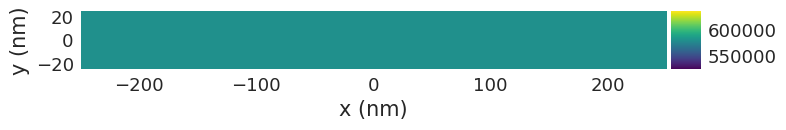

In [18]:
# and let's visualize this strip

system.m.z.plane('z').mpl()

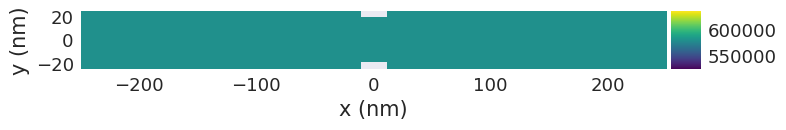

In [30]:
# now we want to make a system where we have two notches in the middle of the strip
# these notches will be used to pin a domain wall

notch_len = 20e-9
notch_depth = 5e-9

# so we define our magnetization norm based on this
# set the value to be zero at the notches
def m_norm(point):
    x, y, z = point
    if ((np.abs(x) >= notch_len/2) or (np.abs(y) <= width/2-notch_depth)) and (np.abs(z) <= thickness/2):
        return Ms
    else:
        return 0

# we will keep the direction of magnetization uniform for now
def m_value(pos):
    x, y, z = pos
    if (np.abs(x) <= length/2) and (np.abs(y) <= width/2) and (np.abs(z) <= thickness/2):
        return (0, 0, 1)
    else:
        return (0, 0, 0)

# initialize our magnetization, and plot
system.m = df.Field(mesh, dim=3, value=m_value, norm=m_norm)
system.m.z.plane('z').mpl()

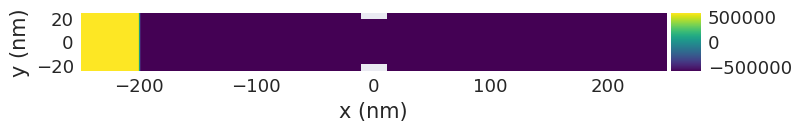

In [31]:
# now we are ready to define specific domains
# make one domain pointing in +z direction for first 50 nm of strip
# after that, magnetization points in -z direction
# we will relax the system and see what the domain wall does to minimize energy

# so here is where we define direction of magnetization
def m_value(pos):
    x, y, z = pos
    if (-length/2 <= x <= -length/2+50e-9) and (np.abs(y) <= width/2) and (np.abs(z) <= thickness/2):
        return (0, 0, 1)
    else:
        return (0, 0, -1)
    
# initialize our magnetization, and plot
system.m = df.Field(mesh, dim=3, value=m_value, norm=m_norm)
system.m.z.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner)[2023/08/19 17:49]... (21.6 s)


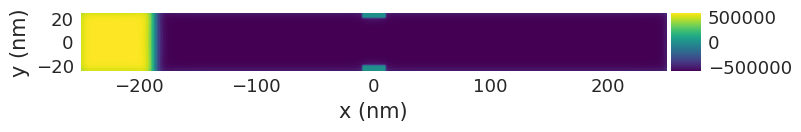

In [32]:
# looks good, now let's relax the system

md = mc.MinDriver()
md.drive(system)

system.m.z.plane('z').mpl.scalar()

In [29]:
# here is a vector field in 3d to visualize what we have
# shows that there are indeed no magnetic moments found in the notches

system.m.k3d.vector()

Output()

Running OOMMF (ExeOOMMFRunner)[2023/08/19 18:00]... (9.9 s)


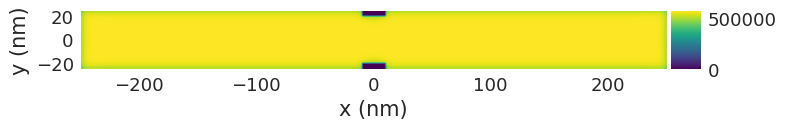

In [36]:
# now we will apply a magnetic field to drive the domain wall across the film
# this means adding in a zeeman energy
# The domain wall has zeeman energy per unit area 2𝜇0MH𝛿x
# so pressure exerted on the wall will be 2𝜇0MH

H = (0, 0, 1.16515e5)  # an external magnetic field (A/m)
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=Ku, u=u) + mm.Zeeman(H=H)

# also reinitialize magnetization
system.m = df.Field(mesh, dim=3, value=m_value, norm=m_norm)

# system minimizing

md = mc.MinDriver()
md.drive(system)

system.m.z.plane('z').mpl.scalar()

In [37]:
system.m.k3d.vector()

Output()

Running OOMMF (ExeOOMMFRunner)[2023/08/19 18:02]... (6.5 s)


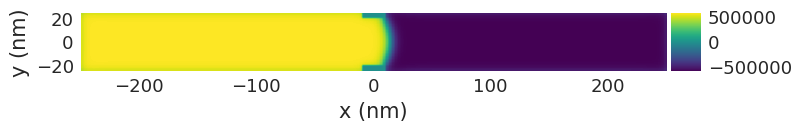

In [41]:
# we found that 1.16515e5 A/M was the minimum needed to drive across this size of notch
# anything less fails, the domain wall is pinned

H = (0, 0, 5e4)  # an external magnetic field (A/m)
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=Ku, u=u) + mm.Zeeman(H=H)

# also reinitialize magnetization
system.m = df.Field(mesh, dim=3, value=m_value, norm=m_norm)

# system minimizing

md = mc.MinDriver()
md.drive(system)

system.m.z.plane('z').mpl.scalar()

Running OOMMF (ExeOOMMFRunner)[2023/08/19 18:05]... (1.9 s)


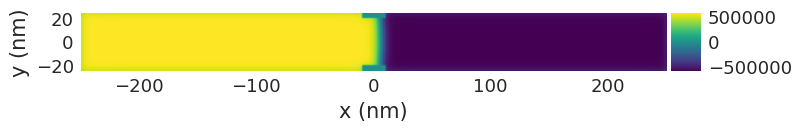

In [42]:
# now, we see how the domain wall is stretching past the notch under the applied field
# this stretching increases with field strength until the wall has enough pressure to move beyond this local minimum
# But, we can also remove the field and minimize again to allow the wall to settle into the local minimum
# which would be the center of the notches

# remove zeeman energy
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=Ku, u=u)

# and let the system relax

md = mc.MinDriver()
md.drive(system)

system.m.z.plane('z').mpl.scalar()

Running OOMMF (ExeOOMMFRunner)[2023/08/19 18:08]... (4.5 s)


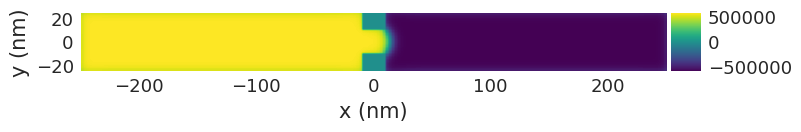

In [43]:
# finally, we can see how the strength of field needed to drive across the film increases
# with the size of the notches...

notch_len = 20e-9
notch_depth = 15e-9

H = (0, 0, 1.16515e5)  # an external magnetic field (A/m)
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=Ku, u=u) + mm.Zeeman(H=H)

# also reinitialize magnetization
system.m = df.Field(mesh, dim=3, value=m_value, norm=m_norm)

# system minimizing

md = mc.MinDriver()
md.drive(system)

system.m.z.plane('z').mpl.scalar()

In [44]:
# we used the same strength field for the notches above as we did for the first notches
# but we see we fail to drive the domain wall all the way across the film
system.m.k3d.vector()

Output()

Running OOMMF (ExeOOMMFRunner)[2023/08/19 18:10]... (7.3 s)


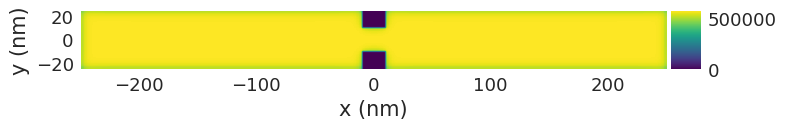

In [45]:
# we need to increase the field...

H = (0, 0, 1.6e5)  # an external magnetic field (A/m)
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=Ku, u=u) + mm.Zeeman(H=H)

# also reinitialize magnetization
system.m = df.Field(mesh, dim=3, value=m_value, norm=m_norm)

# system minimizing

md = mc.MinDriver()
md.drive(system)

system.m.z.plane('z').mpl.scalar()